很高兴向大家介绍我们的基于 [飞桨](https://github.com/PaddlePaddle/Paddle) 开发的可解释性算法开源库 [InterpretDL](https://github.com/PaddlePaddle/InterpretDL)。

本文将向大家介绍如何快速上手 InterpretDL。

We introduce [InterpretDL](https://github.com/PaddlePaddle/InterpretDL), the open source toolkit of interpretation algorithms based on [PaddlePaddle](https://github.com/PaddlePaddle/Paddle).

This is a notebook for quickly getting started with InterpretDL.

# Installation

In [ ]:
# install paddlepaddle (cpu). See https://www.paddlepaddle.org.cn/documentation/docs/zh/install/index_cn.html for other installation ways.
%pip install paddlepaddle>=2.2.2 -i https://mirror.baidu.com/pypi/simple
# or paddlepaddle-gpu

# install interpretdl
%pip install interpretdl -i https://mirror.baidu.com/pypi/simple

In [126]:
import paddle
paddle.__version__

'2.2.2'

# See Around InterpretDL

In [1]:
import interpretdl as it

# version
print('InterpertDL version:', it.__version__)

# available interpretation algorithms
print('InterpretDL algorithms:', it.interpreter.__all__)

InterpertDL version: 0.5.3
InterpretDL algorithms: ['Interpreter', 'InputGradientInterpreter', 'InputOutputInterpreter', 'IntermediateLayerInterpreter', 'LIMECVInterpreter', 'LIMENLPInterpreter', 'GradCAMInterpreter', 'IntGradCVInterpreter', 'IntGradNLPInterpreter', 'SmoothGradInterpreter', 'OcclusionInterpreter', 'GradShapCVInterpreter', 'GradShapNLPInterpreter', 'ScoreCAMInterpreter', 'LRPCVInterpreter', 'RolloutInterpreter', 'TAMInterpreter', 'SmoothGradInterpreterV2', 'ConsensusInterpreter', 'LIMEPriorInterpreter', 'ForgettingEventsInterpreter', 'NormLIMECVInterpreter', 'NormLIMENLPInterpreter']


We have also provided a table, where each implemented interpretation algorithm is categorized by the representation of explanation results and the type of the target model. This taxonomy can be an indicator to find the best suitable algorithm for the target task and model.

| Methods                         | Representation        | Model Type                                     |
|---------------------------------|-----------------------|------------------------------------------------|
| [LIME](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/lime.py)                            | Input Features        | Model-Agnostic                                 |
| [LIME with Prior](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/lime_prior.py)                 | Input Features        | Model-Agnostic                                 |
| [NormLIME/FastNormLIME](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/_normlime_base.py)           | Input Features        | Model-Agnostic                                 |
| [LRP](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/lrp.py)                             | Input Features        | Differentiable* |
| [SmoothGrad](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/smooth_grad.py)                      | Input Features        | Differentiable                                 |
| [IntGrad](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/integrated_gradients.py)                         | Input Features        | Differentiable                                 |
| [GradSHAP](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/gradient_shap.py)                        | Input Features        | Differentiable                                 |
| [Occlusion](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/occlusion.py)                     | Input Features        | Model-Agnostic                                 |
| [GradCAM/CAM](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/gradient_cam.py)                     | Intermediate Features | Specific: CNNs                                 |
| [ScoreCAM](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/score_cam.py)                        | Intermediate Features | Specific: CNNs                                 |
| [Rollout](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/rollout.py)                         | Intermediate Features | Specific: Transformers                         |
| [TAM](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/transition_attention_maps.py)                             | Intermediate Features | Specific: Transformers                         |
| [ForgettingEvents](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/forgetting_events.py)                | Dataset-Level         | Differentiable                                 |
| [TIDY (Training Data Analyzer)](https://github.com/PaddlePaddle/InterpretDL/blob/master/tutorials/TIDY_tutorial.ipynb) | Dataset-Level         | Differentiable                                 |
| [Consensus](https://github.com/PaddlePaddle/InterpretDL/blob/master/interpretdl/interpreter/consensus.py)                       | Features              | Cross-Model                                    |

\* LRP requires that the model is of specific implementations for relevance back-propagation.

# How to Use an Interpreter

Let's see some examples of using interpreters to get explanations of a pretrained ResNet-50.

## Load A Model

In [39]:
import paddle
device = 'gpu:2'
paddle.set_device(device)

from paddle.vision.models import resnet50
paddle_model = resnet50(pretrained=True)
paddle_model.eval()

In [40]:
# print the structure of ResNet-50
paddle_model

ResNet(
  (conv1): Conv2D(3, 64, kernel_size=[7, 7], stride=[2, 2], padding=3, data_format=NCHW)
  (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
  (relu): ReLU()
  (maxpool): MaxPool2D(kernel_size=3, stride=2, padding=1)
  (layer1): Sequential(
    (0): BottleneckBlock(
      (conv1): Conv2D(64, 64, kernel_size=[1, 1], data_format=NCHW)
      (bn1): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      (conv2): Conv2D(64, 64, kernel_size=[3, 3], padding=1, data_format=NCHW)
      (bn2): BatchNorm2D(num_features=64, momentum=0.9, epsilon=1e-05)
      (conv3): Conv2D(64, 256, kernel_size=[1, 1], data_format=NCHW)
      (bn3): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2D(64, 256, kernel_size=[1, 1], data_format=NCHW)
        (1): BatchNorm2D(num_features=256, momentum=0.9, epsilon=1e-05)
      )
    )
    (1): BottleneckBlock(
      (conv1): Conv2D(256, 64, kernel_size=[1, 1

img.shape: (1, 224, 224, 3)
data.shape: (1, 3, 224, 224)


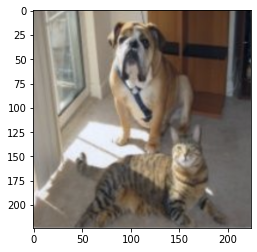

In [44]:
# see an image
import interpretdl as it
import matplotlib.pyplot as plt

img_path = 'assets/catdog.png'
img, data = it.data_processor.readers.images_transform_pipeline(img_path)
print('img.shape:', img.shape)  # img for visualization
print('data.shape:', data.shape)  # data for computation.

plt.imshow(img[0])
plt.show()

In [ ]:
# get human readable labels
!wget -c https://github.com/PaddlePaddle/InterpretDL/files/8561411/readable_label.txt -P ./assets/
f = open('assets/readable_label.txt', 'r')
lines = f.readlines()

In [76]:
# see the predicted top 5 probabilites
probability = paddle.nn.Softmax()(paddle_model(paddle.to_tensor(data)))
topvalues, top_ids = paddle.topk(probability, 5)

print('The model gives the predictions as follows:')
for cls_prob, cls_id in zip(topvalues[0].numpy(), top_ids[0].numpy()):
    print(f'\tprobability: {cls_prob:.5f} ({lines[cls_id].strip()})')

The model gives the predictions as follows:
	probability: 0.32404 (243 bull mastiff)
	probability: 0.10677 (282 tiger cat)
	probability: 0.09738 (292 tiger, Panthera tigris)
	probability: 0.08319 (281 tabby, tabby cat)
	probability: 0.03909 (285 Egyptian cat)


### A question is naturally arised: Why this model predicts to `bull mastiff` and `tiger cat` with highest probabilities?

## InterpretDL shows explanations with two lines

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.41it/s]


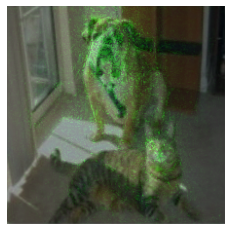

In [91]:
algo = it.SmoothGradInterpreter(paddle_model, device=device)
explanation = algo.interpret(img_path, labels=243)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:20<00:00, 148.74it/s]


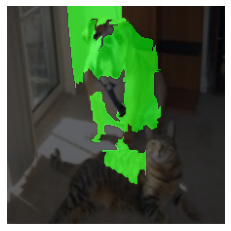

In [94]:
algo = it.LIMECVInterpreter(paddle_model, device=device)
explanation = algo.interpret(img_path, interpret_class=243, num_samples=3000)

`interpret` has an argument `visual` (defaults to `True`), so each time calling `interpret`, a visualization is shown. `labels` or `interpret_class` is the class index to interpret.

Both `SmoothGradInterpreter` and `LIMECVInterpreter` show the explanations of the prediction `243 (bull mastiff)`, which are aligned with the dog. How about the explanations for `282 (tiger cat)`? We can simply change the class index to interpret.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 20.33it/s]


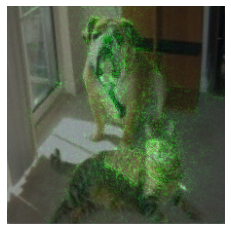

In [98]:
algo = it.SmoothGradInterpreter(paddle_model, device=device)
explanation = algo.interpret(img_path, labels=282)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:20<00:00, 147.36it/s]


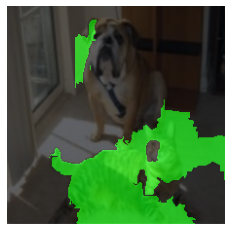

In [95]:
algo = it.LIMECVInterpreter(paddle_model, device=device)
explanation = algo.interpret(img_path, interpret_class=282, num_samples=3000)

We can see that `LIMECVInterpreter` gives the explanation on the cat, while `SmoothGradInterpreter` on both the dog and the cat. Because `SmoothGradInterpreter` and other input-gradient based interpretation algorithms, their visualizations are based on the norm of explanations along the color channel. Some information may be hidden and more analyses should be done.

## More Interpreters

More `Interpreters` are shown here. As we can see, all of them share the same function `interpret` while their arguments are slightly different.

### GradCAM

`GradCAMInterpreter` needs a layer name.

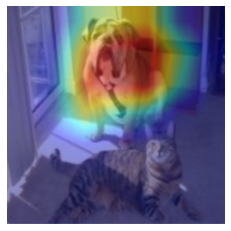

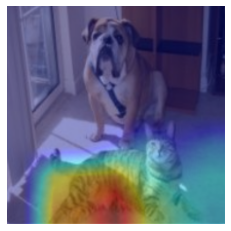

In [122]:
algo = it.GradCAMInterpreter(paddle_model, device=device)
explanation = algo.interpret(img_path, 'layer4.2.conv3', label=243)
explanation = algo.interpret(img_path, 'layer4.2.conv3', label=282)

### IntGrad
`IntGradCVInterpreter` needs a `baselines`.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.20it/s]


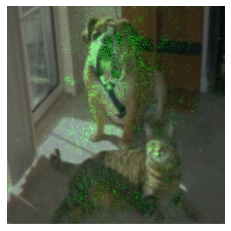

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:18<00:00, 27.35it/s]


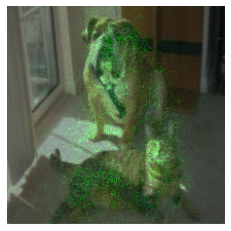

In [124]:
algo = it.IntGradCVInterpreter(paddle_model, device=device)
explanation = algo.interpret(img_path, baselines='random', labels=243)
explanation = algo.interpret(img_path, baselines='random', labels=282)

We have finished the getting-started tutorial. We have also provided other tutorials, each of them focusing on one specific subject, e.g., deep investigation of algorithms based on input gradients, LIME and its variants, NLP tasks and models, explanations for Transformers, dataset-level interpretations, evaluations of interpretation algorithms' trustworthiness, and so on.

Welcome to contribute and build a better `InterpretDL`!